# Wildlife Camera Trap Classification with Azure Custom Vision
*A Microsoft AI Services Tutorial for Research*

## What This Demonstrates

**Microsoft Custom Vision** for automated wildlife monitoring. We'll show how to:

- Set up an Azure Custom Vision project 
- Train a model with minimal wildlife data
- Use the prediction API for batch processing
- Export results for research analysis

**Why Custom Vision for Research:**
- **No ML expertise required** - visual training interface
- **Small data friendly** - works with as few as 5 images per category  
- **Research-ready APIs** - confidence scores and batch processing
- **Scalable** - handles thousands of images via REST API

**Learning Objectives:**
By the end of this tutorial, you will understand how to create a custom image classification model that can automatically identify wildlife species in camera trap images, demonstrating the practical application of AI in ecological research.

## Setup: Install Required Packages

Before we begin, we need to install the necessary Python packages for working with Azure Custom Vision. These packages provide the tools to communicate with Azure's AI services and handle image processing.

**Follow the steps in the online teaching resource to set up your Azure Custom Vision credentials, then resume your journey in this notebook.**

In [ ]:
# Install required packages for Azure Custom Vision and image processing
!pip install azure-cognitiveservices-vision-customvision
!pip install azure-cognitiveservices-vision-computervision  
!pip install pillow matplotlib pandas requests

## Import Libraries

Now we'll import all the necessary libraries for our wildlife classification project. These include Azure AI services, image processing tools, and data analysis libraries.

**You don't need to understand the details of these imports** - simply run this cell to make the required functionality available.

In [ ]:
# Import libraries for Azure Custom Vision, image processing, and data analysis
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry
from msrest.authentication import ApiKeyCredentials
from PIL import Image as PILImage
import matplotlib.pyplot as plt
import pandas as pd
import requests
import time
import io

## Azure Custom Vision Configuration

This cell establishes the connection to your Azure Custom Vision service using the credentials you obtained from the Azure Portal. The main lesson resource pages give specific instruction on where to find this information. Be sure to follow these before continuing.

**Replace the placeholder values below with your actual Azure Custom Vision credentials:**

- **ENDPOINT**: Your Custom Vision service endpoint URL
- **TRAINING_KEY**: API key for training operations  
- **PREDICTION_KEY**: API key for prediction operations
- **PREDICTION_RESOURCE_ID**: Full resource path for predictions

These credentials allow the notebook to communicate securely with your Azure AI services.

In [4]:
# Azure Custom Vision credentials - replace with your actual values from Azure Portal
ENDPOINT = "https://wildlifcvtraining.cognitiveservices.azure.com/"
TRAINING_KEY = "7WWPYK2Mf1cNBf3OCt03IYDSUxXJBf3evk0K19nw9jX8sycOWV0MJQQJ99BFACmepeSXJ3w3AAAJACOGPMWd"
PREDICTION_KEY = "8ZwAr0SSA5j99m0gSJ7U1eDmKd9JFUwvdrVUq5kvbb8UgjNo1HGcJQQJ99BFACmepeSXJ3w3AAAIACOGBNdN" 
PREDICTION_RESOURCE_ID = "/subscriptions/2271c77a-d15b-4a67-af97-752c03a7bb65/resourceGroups/adamlee/providers/Microsoft.CognitiveServices/accounts/wildlifcvtraining-Prediction"

# Initialize Azure Custom Vision clients
training_credentials = ApiKeyCredentials(in_headers={"Training-key": TRAINING_KEY})
trainer = CustomVisionTrainingClient(ENDPOINT, training_credentials)

prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": PREDICTION_KEY})
predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)

print("Custom Vision clients successfully initialized")
print("Ready to proceed with wildlife classification project")

Custom Vision clients successfully initialized
Ready to proceed with wildlife classification project


## Project Setup: Wildlife Classification Project

This cell defines a function that sets up a new Custom Vision project for classifying animals captured in camera trap images. It ensures that appropriate tags (categories) are created, and that repeated runs do not create duplicates—avoiding issues with Azure’s free tier rate limits.

**This function will:**
- Create a Custom Vision project named **"Wildlife Camera Trap Classifier"**
- Add the following ten tags to the project:
  - deer, fox, bear, raccoon, coyote, rabbit, squirrel, bird, empty (no animal), and human

> ⚠️ **Important**: Run this cell only once. If re-run, you may encounter Azure rate limits. The function includes logic to detect and use an existing project if one is already available.

In [ ]:
def setup_wildlife_project():
    """
    Set up Custom Vision project for wildlife classification.
    Handles existing projects and rate limits gracefully.
    """
    
    print("Setting up Wildlife Classification Project...")
    
    try:
        # Check for existing Wildlife projects to avoid duplicates
        existing_projects = trainer.get_projects()
        wildlife_projects = [p for p in existing_projects if "Wildlife" in p.name]
        
        if wildlife_projects:
            # Use existing project
            project = wildlife_projects[-1]  # Use most recent
            print(f"Using existing project: {project.name}")
            print(f"Project ID: {project.id}")
            
            # Get existing tags from project
            existing_tags = trainer.get_tags(project.id)
            if existing_tags:
                tags = {tag.name: tag for tag in existing_tags}
                print(f"Found {len(tags)} existing categories: {list(tags.keys())}")
                return project, tags
            else:
                print("Project exists but no categories found. Creating categories...")
                
        else:
            # Create new project
            print("Creating new Wildlife Camera Trap Classifier project...")
            project = trainer.create_project(
                "Wildlife Camera Trap Classifier",
                description="Classify animals from camera trap images for ecological research"
            )
            print(f"Project created successfully: {project.id}")
        
        # Create classification categories (tags)
        categories = [
            "deer", "fox", "bear", "raccoon", "coyote", 
            "rabbit", "squirrel", "bird", "empty", "human"
            ]
        
        tags = {}
        print("Setting up classification categories...")
        
        for category in categories:
            tag = trainer.create_tag(project.id, category)
            tags[category] = tag
            print(f"Created category: {category}")
        
        print(f"Setup complete! Ready to train with {len(tags)} categories.")
        return project, tags
        
    except Exception as e:
        if "Too Many Requests" in str(e):
            print("Rate limit reached. Please wait 15-30 minutes and try again.")
            print("Alternatively, create a new Custom Vision resource in Azure Portal.")
        else:
            print(f"Setup error: {e}")
        return None, None

# Execute project setup
project, tags = setup_wildlife_project()

# Verify setup success
if project and tags:
    print(f"\nProject setup successful!")
    print(f"Project Name: {project.name}")
    print(f"Available Categories: {len(tags)} wildlife types")
    print("Ready to proceed with training data upload")
else:
    print("\nSetup incomplete. Please resolve rate limits or check credentials.")

Setting up Wildlife Classification Project...
Using existing project: Wildlife Camera Trap Classifier
Project ID: d897507d-185e-49ce-858c-d4d3c58e300b
Found 9 existing categories: ['deer', 'empty', 'squirrel', 'fox', 'coyote', 'raccoon', 'bird', 'bear', 'rabbit']

Project setup successful!
Project Name: Wildlife Camera Trap Classifier
Available Categories: 9 wildlife types
Ready to proceed with training data upload


## Training Data: Wildlife Image URLs

This cell defines our training dataset using a Python dictionary. Each category (deer, fox, bear, etc.) is associated with a list of image URLs from Wikimedia Commons - a free, public repository of wildlife photographs.

**How this works:**
- Each key in the dictionary represents an animal category
- Each value is a list of 5-6 image URLs showing that animal (note, you MUST have at least 5 images per tag)
- These images will be downloaded and used to train our Custom Vision model
- The model learns to recognize patterns that distinguish each animal type

**For research applications**, you would replace these URLs with images from your own camera trap surveys. Custom Vision works best with 10-50 images per category, representing different angles, lighting conditions, and individual animals.

In [ ]:
# Training dataset: URLs of wildlife images from Wikimedia Commons
# Each category contains 5-6 representative images for model training
image_data = {
    "deer": [
        "https://upload.wikimedia.org/wikipedia/commons/5/52/20190121_Nara_deer-3.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/b/b2/Sika_Deer_in_Nara%2C_Japan%2C_20240819_1546_4782.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/0/02/Baluran%27s_Deer_Family_Chandra_Musliminnata.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/9/9a/20190121_Nara_deer-10.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/3/33/Deer_walking_in_the_snow.jpg"
    ],
    
    "fox": [
        "https://upload.wikimedia.org/wikipedia/commons/0/03/Vulpes_vulpes_laying_in_snow.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/d/d5/Vulpes_vulpes_sitting.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/d/d9/Culpeo_MC.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/c/cc/Portrait_of_a_red_fox_in_Rautas_fj%C3%A4llurskog.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/d/d8/Hungry_Fox_%288152689861%29.jpg"
    ],
    
    "bear": [
        "https://upload.wikimedia.org/wikipedia/commons/5/5d/Kamchatka_Brown_Bear_near_Dvuhyurtochnoe_on_2015-07-23.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/7/7f/European_Brown_Bear.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/5/54/Closeup_kodiak_bear_hamburg.JPG", 
        "https://upload.wikimedia.org/wikipedia/commons/2/2a/Brown_bear_%28Ursus_arctos_arctos%29_running.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/6/6b/Kodiak_Brown_Bear.jpg"
    ],
    
    "raccoon": [
        "https://upload.wikimedia.org/wikipedia/commons/9/99/Raccoon_%28Procyon_lotor%29_3.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/d/dd/Waschb%C3%A4r_Procyon_lotor-7318.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/3/3e/Raccoon_in_Central_Park_%2835264%29.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/f/fe/Procyon_lotor_%28Common_raccoon%29.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/8/8b/Procyon_lotor_%28raccoon%29.jpg"
    ],
    
    "coyote": [
        "https://upload.wikimedia.org/wikipedia/commons/a/af/Canis_latrans.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/2/20/Coyote_Tule_Lake_CA.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/d/db/Mother_Coyote_Sitting%2C_Watching_Over_Den%2C_Photo_1_of_2_%2847924154788%29.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/2/26/Coyote_%28Canis_latrans%29_DSC1747vv.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/4/48/Coyote_%28Canis_latrans%29_DSC2777a.jpg"
    ],
    
    "rabbit": [
        "https://upload.wikimedia.org/wikipedia/commons/f/fa/Bunny_rabbit_at_Alligator_Bay%2C_Beauvoir%2C_France.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/b/b7/Trix_the_rabbit.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/e/ef/Rabbit_in_Richmond_BC.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/8/8c/Rabbit_%28Oryctolagus_cuniculus%29_Skomer.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/3/37/Oryctolagus_cuniculus_Tasmania_2.jpg"
    ], 
    
    "squirrel": [
        "https://upload.wikimedia.org/wikipedia/commons/b/bd/Red_squirrel_%2821808%29.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/0/07/Grey_squirrel_%28Sciurus_carolinensis%29_02.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/7/7c/Eastern_Grey_Squirrel_in_St_James%27s_Park%2C_London_-_Nov_2006_edit.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/0/02/Eichh%C3%B6rnchen_D%C3%BCsseldorf_Hofgarten_edit.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/8/87/Squirrel_eating_nut_in_grass.png"
    ],
    
    "bird": [
        "https://upload.wikimedia.org/wikipedia/commons/f/fb/Brown_thrasher_in_CP_%2802147%29.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/e/e1/Sitta_europaea_wildlife_3.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/2/2e/Crested_Tern_-_Mortimer_Bay.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/3/33/Gyps_rueppellii_-Nairobi_National_Park%2C_Kenya-8-4c.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/e/ec/Ara_ararauna_Luc_Viatour.jpg"
    ],
    
    "empty": [
        "https://upload.wikimedia.org/wikipedia/commons/b/be/Hutan_Tangkahan.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/3/34/D%C3%BClmen%2C_Naturschutzgebiet_-Am_Enteborn-_--_2014_--_0202.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/3/3d/Sossusvlei_south_view.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/9/90/Everest%2C_Himalayas.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/a/a5/Ponta_de_S%C3%A3o_Louren%C3%A7o_north_north_east.jpg"
    ],
    
    "human": [
        "https://upload.wikimedia.org/wikipedia/commons/0/07/Isabella_L%C3%B6vin_signing_climate_law_referral.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/c/cc/People_in_JHB.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/8/89/Folk_Dance%2C_Odisha_India.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/0/0c/Sally_Ride_%281984%29.jpg", 
        "https://upload.wikimedia.org/wikipedia/commons/f/f4/People_of_Butte_County_%E2%80%93_Tod_Kimmelshue_%282025%29-104A8815.jpg"
    ]
}

# Display training data summary
print("Training dataset summary:")
total_images = sum(len(urls) for urls in image_data.values())
print(f"Total categories: {len(image_data)}")
print(f"Total training images: {total_images}")
print("\nImages per category:")
for category, urls in image_data.items():
    print(f"  {category}: {len(urls)} images")

Training dataset summary:
Total categories: 1
Total training images: 5

Images per category:
  bear: 5 images


## Upload Training Images to Custom Vision

This function uploads training images to your Custom Vision project using a multi-label classification approach. It automates several tasks to streamline the upload process and ensure robustness.

**What the function does:**
- Automatically resizes images that exceed Azure’s 6MB upload limit
- Downloads images using appropriate headers to avoid being blocked by remote servers
- Includes error handling to skip over problematic images without halting execution
- Displays upload progress for each category

**Upload process:**
1. Downloads each image from its specified URL
2. Resizes images where necessary
3. Assigns each image to its corresponding tag (category)
4. Uploads the final images to your Custom Vision project

> ⏱️ This step may take several minutes depending on your internet speed and the number of images.

In [32]:
def upload_training_images(project_id, tags, training_data):
    """
    Upload training images to Custom Vision with automatic optimization.
    
    Features:
    - Handles large images (resizes automatically)
    - Proper headers for reliable downloads
    - Progress tracking and error handling
    - Ensures images stay under Custom Vision's 6MB limit
    """
    
    print("Starting training image upload...")
    print(f"Processing {len(training_data)} categories...")
    
    # Configuration for reliable downloads and processing
    headers = {'User-Agent': 'Mozilla/5.0 (compatible; Educational-Bot)'}
    max_file_size = 4 * 1024 * 1024  # 4MB target (buffer below 6MB limit)
    uploaded_count = 0
    
    def optimize_image_size(image_content, target_size=max_file_size):
        """Optimize image to fit Custom Vision size requirements."""
        try:
            img = PILImage.open(io.BytesIO(image_content))
            
            # Convert to RGB if necessary
            if img.mode in ('RGBA', 'P'):
                img = img.convert('RGB')
            
            # Start with reasonable dimensions
            max_dimension = 800
            quality = 70
            
            while max_dimension >= 200:  # Don't go below 200px
                # Resize image
                img_resized = img.copy()
                img_resized.thumbnail((max_dimension, max_dimension), PILImage.Resampling.LANCZOS)
                
                # Try different quality levels
                for q in [quality, quality-15, quality-30, quality-45]:
                    if q < 30:  # Don't go below 30% quality
                        continue
                        
                    img_bytes = io.BytesIO()
                    img_resized.save(img_bytes, format='JPEG', quality=q, optimize=True)
                    
                    if len(img_bytes.getvalue()) <= target_size:
                        print(f"    Optimized: {max_dimension}px, {q}% quality, {len(img_bytes.getvalue())/1024:.0f}KB")
                        return img_bytes.getvalue()
                
                # If still too large, reduce dimensions
                max_dimension -= 100
                
            # Final fallback - very small image
            img_tiny = img.copy()
            img_tiny.thumbnail((200, 200), PILImage.Resampling.LANCZOS)
            img_bytes = io.BytesIO()
            img_tiny.save(img_bytes, format='JPEG', quality=30, optimize=True)
            
            final_size = len(img_bytes.getvalue())
            print(f"    Final fallback: 200px, 30% quality, {final_size/1024:.0f}KB")
            return img_bytes.getvalue()
            
        except Exception as e:
            print(f"    Image optimization failed: {e}")
            return None
    
    for category, image_urls in training_data.items():
        if category not in tags:
            print(f"Skipping unknown category: {category}")
            continue
            
        print(f"\nUploading {category} ({len(image_urls)} images)...")
        category_success = 0
        
        for i, url in enumerate(image_urls, 1):
            try:
                # Download image with proper headers
                print(f"  {i}/{len(image_urls)}: Downloading...")
                response = requests.get(url, headers=headers, timeout=15)
                if response.status_code != 200:
                    print(f"  {i}/{len(image_urls)}: Download failed (HTTP {response.status_code})")
                    continue
                
                original_size = len(response.content)
                print(f"    Original size: {original_size/1024/1024:.1f}MB")
                
                # Optimize image size if needed
                if original_size > max_file_size:
                    print(f"    Optimizing image (too large)...")
                    optimized_content = optimize_image_size(response.content)
                    if optimized_content is None:
                        print(f"  {i}/{len(image_urls)}: Optimization failed")
                        continue
                    image_content = optimized_content
                else:
                    image_content = response.content
                    print(f"    Size OK: {len(image_content)/1024:.0f}KB")
                
                # Create image entry for Custom Vision
                image_entry = ImageFileCreateEntry(
                    name=f"{category}_{i}.jpg",
                    contents=image_content,
                    tag_ids=[tags[category].id]
                )
                
                # Upload to Custom Vision
                print(f"    Uploading to Custom Vision...")
                result = trainer.create_images_from_files(
                    project_id, ImageFileCreateBatch(images=[image_entry])
                )
                
                if result.is_batch_successful:
                    uploaded_count += 1
                    category_success += 1
                    print(f"  {i}/{len(image_urls)}: ✅ Success")
                else:
                    # Get more detailed error info
                    if result.images:
                        error_status = result.images[0].status
                        print(f"  {i}/{len(image_urls)}: ❌ Upload failed - {error_status}")
                    else:
                        print(f"  {i}/{len(image_urls)}: ❌ Upload failed - unknown error")
                    
            except Exception as e:
                print(f"  {i}/{len(image_urls)}: ❌ Error - {str(e)[:100]}...")
        
        print(f"  {category} complete: {category_success}/{len(image_urls)} images uploaded")
    
    print(f"\nUpload complete!")
    print(f"Total images successfully uploaded: {uploaded_count}")
    
    if uploaded_count > 0:
        print("Your Custom Vision project now has training data and is ready for model training.")
    else:
        print("No images were uploaded. Check the detailed errors above.")
    
    return uploaded_count

# Execute the upload process
if project and tags:
    uploaded_images = upload_training_images(project.id, tags, image_data)
    
    if uploaded_images > 0:
        print(f"\nSuccess! {uploaded_images} images uploaded to Custom Vision.")
        print("Proceed to the next section to train your wildlife classification model.")
    else:
        print("\nNo images were uploaded successfully.")
        print("Please check your internet connection and try again.")
else:
    print("Cannot upload images - project setup was not successful.")
    print("Please run the project setup cell first.")

Starting training image upload...
Processing 1 categories...

Uploading bear (5 images)...
  1/5: Downloading...
    Original size: 5.5MB
    Optimizing image (too large)...
    Optimized: 800px, 70% quality, 90KB
    Uploading to Custom Vision...
  1/5: ❌ Upload failed - OKDuplicate
  2/5: Downloading...
    Original size: 7.4MB
    Optimizing image (too large)...
    Optimized: 800px, 70% quality, 95KB
    Uploading to Custom Vision...
  2/5: ✅ Success
  3/5: Downloading...
    Original size: 0.8MB
    Size OK: 840KB
    Uploading to Custom Vision...
  3/5: ❌ Upload failed - OKDuplicate
  4/5: Downloading...
    Original size: 2.4MB
    Size OK: 2507KB
    Uploading to Custom Vision...
  4/5: ❌ Upload failed - OKDuplicate
  5/5: Downloading...
    Original size: 0.1MB
    Size OK: 140KB
    Uploading to Custom Vision...
  5/5: ❌ Upload failed - OKDuplicate
  bear complete: 1/5 images uploaded

Upload complete!
Total images successfully uploaded: 1
Your Custom Vision project now has t

You have now successfully completed the setup and data upload phase of our wildlife classification tutorial.

**What you've accomplished:**
- ✅ Set up Azure Custom Vision project with 10 wildlife categories
- ✅ Defined training dataset with representative wildlife images
- ✅ Uploaded training images to Custom Vision service
- ✅ Your AI model now has the data it needs for training

**Next steps:**
- Train your custom wildlife classification model
- Test the model on new wildlife images
- Explore batch processing capabilities for research
- Learn about model evaluation and improvement techniques

**Research applications:** This same workflow can be adapted for any wildlife monitoring project by substituting your own camera trap images for the training dataset.

## Train the Wildlife Classifier

This function initiates training for your Custom Vision model using the tags and images you have uploaded.

Once triggered, it sends a training request to Azure, which may take a few minutes depending on the dataset size.

> You must run this cell after uploading all images. Do not proceed to prediction steps until training has completed.

In [33]:
## Train the Wildlife Classification Model

def train_wildlife_classifier(project_id):
    """
    Train the Custom Vision wildlife classification model with progress tracking.
    
    Features:
    - Starts model training with your uploaded images
    - Shows training progress every 5 seconds
    - Confirms when model is ready for predictions
    """
    
    print("🚀 Starting wildlife classification model training...")
    print("This process typically takes 2-5 minutes depending on data size.")
    print("=" * 60)
    
    try:
        # Start the training process
        print("⏳ Initiating training...")
        iteration = trainer.train_project(project_id)
        
        # Track training progress
        import time
        start_time = time.time()
        last_update = 0
        
        print(f"📚 Training iteration: {iteration.name}")
        print(f"🔄 Training status: {iteration.status}")
        print()
        
        # Monitor training progress
        while iteration.status == "Training":
            current_time = time.time()
            elapsed = current_time - start_time
            
            # Update every 5 seconds
            if elapsed - last_update >= 5:
                minutes = int(elapsed // 60)
                seconds = int(elapsed % 60)
                print(f"⏰ Training in progress... {minutes:02d}:{seconds:02d} elapsed")
                last_update = elapsed
            
            # Wait 2 seconds before checking status again
            time.sleep(2)
            iteration = trainer.get_iteration(project_id, iteration.id)
        
        # Training completed - show final status
        total_time = time.time() - start_time
        minutes = int(total_time // 60)
        seconds = int(total_time % 60)
        
        print()
        print("=" * 60)
        
        if iteration.status == "Completed":
            print("🎉 Training completed successfully!")
            print(f"⏱️  Total training time: {minutes:02d}:{seconds:02d}")
            print(f"🏷️  Model iteration: {iteration.name}")
            print()
            print("✅ Your wildlife classifier is now ready for predictions!")
            print("📊 Model performance metrics:")
            
            # Display training metrics if available
            if hasattr(iteration, 'precision') and iteration.precision is not None:
                print(f"   • Precision: {iteration.precision:.1%}")
            if hasattr(iteration, 'recall') and iteration.recall is not None:
                print(f"   • Recall: {iteration.recall:.1%}")
            
            print()
            print("🔬 Proceed to the next section to test your model with wildlife images!")
            return iteration
            
        else:
            print(f"❌ Training failed with status: {iteration.status}")
            if hasattr(iteration, 'error_details'):
                print(f"   Error details: {iteration.error_details}")
            return None
            
    except Exception as e:
        print(f"❌ Training error: {e}")
        print("💡 Common solutions:")
        print("   • Ensure you have uploaded training images to your project")
        print("   • Check your Azure Custom Vision credentials")
        print("   • Verify your internet connection")
        print("   • Try again in a few minutes if you hit rate limits")
        return None

# Execute model training
if project and tags:
    print("Starting training with your wildlife dataset...")
    print(f"Project: {project.name}")
    print(f"Categories: {len(tags)} wildlife types")
    print()
    
    # Start training
    trained_iteration = train_wildlife_classifier(project.id)
    
    if trained_iteration:
        print(f"\n🌟 Success! Your wildlife classifier '{project.name}' is trained and ready.")
        print("The model can now automatically identify:")
        for category in sorted(tags.keys()):
            print(f"   🐾 {category.title()}")
    else:
        print("\n⚠️ Training was not successful. Please check the error messages above.")
        
else:
    print("❌ Cannot start training - project setup was not successful.")
    print("Please run the project setup and image upload cells first.")

Starting training with your wildlife dataset...
Project: Wildlife Camera Trap Classifier
Categories: 9 wildlife types

🚀 Starting wildlife classification model training...
This process typically takes 2-5 minutes depending on data size.
⏳ Initiating training...
📚 Training iteration: Iteration 1
🔄 Training status: Training

⏰ Training in progress... 00:06 elapsed
⏰ Training in progress... 00:12 elapsed
⏰ Training in progress... 00:18 elapsed
⏰ Training in progress... 00:24 elapsed
⏰ Training in progress... 00:30 elapsed
⏰ Training in progress... 00:36 elapsed
⏰ Training in progress... 00:42 elapsed
⏰ Training in progress... 00:48 elapsed
⏰ Training in progress... 00:54 elapsed
⏰ Training in progress... 01:01 elapsed
⏰ Training in progress... 01:07 elapsed
⏰ Training in progress... 01:13 elapsed
⏰ Training in progress... 01:20 elapsed
⏰ Training in progress... 01:27 elapsed
⏰ Training in progress... 01:33 elapsed
⏰ Training in progress... 01:39 elapsed
⏰ Training in progress... 01:45 ela

## Evaluate Model Performance

This function retrieves and displays summary statistics for the model's performance on the training data. Similar to the Custom Vision web interface, it provides precision and recall metrics for each tag.

**This allows you to:**
- Review how well your model has learned to distinguish between classes
- Identify any categories that may need more training data

> Review the metrics before proceeding to publishing or testing, as they help assess whether the model is ready for deployment.

In [34]:
## Model Performance Evaluation

def display_model_performance(project_id):
    """
    Display performance metrics and details for the trained wildlife classification model.
    
    Features:
    - Shows iteration details (number, training date/time)
    - Displays overall model performance metrics
    - Shows per-category performance if available
    - Explains what the metrics mean for wildlife research
    """
    
    try:
        # Get all iterations for the project
        iterations = trainer.get_iterations(project_id)
        
        if not iterations:
            print("❌ No trained models found for this project.")
            print("Please run the training cell first to create a model.")
            return None
        
        # Get the latest iteration (most recent training)
        latest_iteration = iterations[0]  # Iterations are returned in descending order
        
        print("🔍 WILDLIFE CLASSIFIER PERFORMANCE EVALUATION")
        print("=" * 55)
        print()
        
        # Display iteration details
        print("📋 MODEL DETAILS:")
        print(f"   🏷️  Iteration Name: {latest_iteration.name}")
        print(f"   🔢 Iteration ID: {latest_iteration.id}")
        print(f"   📅 Training Date: {latest_iteration.created.strftime('%Y-%m-%d %H:%M:%S UTC')}")
        print(f"   ⚡ Status: {latest_iteration.status}")
        print(f"   ⏱️  Training Duration: {latest_iteration.training_time_in_minutes} minutes")
        print()
        
        # Get detailed performance metrics
        try:
            performance = trainer.get_iteration_performance(project_id, latest_iteration.id)
            
            print("📊 OVERALL MODEL PERFORMANCE:")
            print(f"   🎯 Precision: {performance.precision:.1%}")
            print(f"   🔄 Recall: {performance.recall:.1%}")
            print(f"   ⚖️  Average Precision: {performance.average_precision:.1%}")
            print()
            
            # Explain what these metrics mean
            print("💡 WHAT THESE METRICS MEAN:")
            print("   • Precision: When the model predicts an animal, how often is it correct?")
            print("   • Recall: Of all actual animals, how many did the model find?")
            print("   • Average Precision: Overall accuracy across all wildlife categories")
            print()
            
            # Display per-tag performance if available
            if hasattr(performance, 'per_tag_performance') and performance.per_tag_performance:
                print("🐾 PER-CATEGORY PERFORMANCE:")
                print("   Category        Precision    Recall      Avg Precision")
                print("   " + "-" * 50)
                
                for tag_perf in performance.per_tag_performance:
                    tag_name = tag_perf.name.ljust(12)
                    precision = f"{tag_perf.precision:.1%}".ljust(10)
                    recall = f"{tag_perf.recall:.1%}".ljust(10)
                    avg_precision = f"{tag_perf.average_precision:.1%}"
                    print(f"   {tag_name}  {precision}  {recall}  {avg_precision}")
                print()
            
            # Performance interpretation
            print("📈 PERFORMANCE INTERPRETATION:")
            if performance.average_precision >= 0.9:
                print("   🌟 Excellent! Your model performs very well for wildlife classification.")
            elif performance.average_precision >= 0.8:
                print("   ✅ Good performance! Suitable for most wildlife monitoring tasks.")
            elif performance.average_precision >= 0.7:
                print("   ⚠️  Moderate performance. Consider adding more training images.")
            else:
                print("   📚 Lower performance. More diverse training data recommended.")
            
            print()
            print("🔬 RESEARCH APPLICATIONS:")
            print("   • Camera trap image processing")
            print("   • Automated wildlife monitoring")
            print("   • Biodiversity surveys")
            print("   • Conservation research")
            
            return latest_iteration
            
        except Exception as perf_error:
            print("⚠️  Could not retrieve detailed performance metrics.")
            print(f"   Error: {perf_error}")
            print("   The model is still functional for predictions.")
            return latest_iteration
            
    except Exception as e:
        print(f"❌ Error retrieving model information: {e}")
        print("💡 Make sure your project has been set up and a model has been trained.")
        return None

# Display model performance
if project:
    print("Evaluating your trained wildlife classification model...")
    print()
    
    model_info = display_model_performance(project.id)
    
    if model_info:
        print()
        print("✅ Model evaluation complete!")
        print("🚀 Your wildlife classifier is ready for testing with new images.")
    else:
        print()
        print("⚠️  Unable to evaluate model. Please ensure training has been completed.")
        
else:
    print("❌ Project not found. Please run the project setup cell first.")

Evaluating your trained wildlife classification model...

🔍 WILDLIFE CLASSIFIER PERFORMANCE EVALUATION

📋 MODEL DETAILS:
   🏷️  Iteration Name: Iteration 1
   🔢 Iteration ID: 12c5b161-f9cb-41ed-befd-6ca98aa7d1d7
   📅 Training Date: 2025-06-28 18:35:10 UTC
   ⚡ Status: Completed
   ⏱️  Training Duration: 1 minutes

📊 OVERALL MODEL PERFORMANCE:
   🎯 Precision: 100.0%
   🔄 Recall: 55.6%
   ⚖️  Average Precision: 100.0%

💡 WHAT THESE METRICS MEAN:
   • Precision: When the model predicts an animal, how often is it correct?
   • Recall: Of all actual animals, how many did the model find?
   • Average Precision: Overall accuracy across all wildlife categories

🐾 PER-CATEGORY PERFORMANCE:
   Category        Precision    Recall      Avg Precision
   --------------------------------------------------
   bear          100.0%      100.0%      100.0%
   bird          0.0%        0.0%        100.0%
   coyote        100.0%      100.0%      100.0%
   deer          0.0%        0.0%        100.0%
   emp

## Testing Images:

Next, we will prepare a Python dictionary containing 5 new remotely-hosted images of a bear, racoon, rabbit, fox and empty landscape. In order for us to test how well our trained model can predict each of these tags, we must firstly make sure the images are in an acceptable format for testing.

In [27]:
testing_images = {
    "test_image_1": "https://upload.wikimedia.org/wikipedia/commons/7/71/2010-kodiak-bear-1.jpg",
    "test_image_2": "https://upload.wikimedia.org/wikipedia/commons/5/5b/Racoon_%2820091106%29.JPG", 
    "test_image_3": "https://upload.wikimedia.org/wikipedia/commons/3/37/Oryctolagus_cuniculus_Tasmania_2.jpg",
    "test_image_4": "https://upload.wikimedia.org/wikipedia/commons/6/6c/Red_fox_%28Vulpes_vulpes_crucigera%29_Skalnate_Pleso_2.jpg",
    "test_image_5": "https://upload.wikimedia.org/wikipedia/commons/9/91/Schwanenstein%2C_Lohme%2C_Insel_R%C3%BCgen%2C_170422%2C_ako_%283%29.jpg"
}

## Download and Preview Test Images

This function downloads test images from the URLs defined in your test dictionary. It ensures each image is properly resized and formatted before previewing them in a grid.

**What the function does:**
- Downloads each test image using its associated key
- Resizes images to optimal dimensions for inference
- Displays a preview grid of all test images alongside their category labels (dictionary keys)

> This visual preview helps confirm your test set is properly structured before making predictions.

Processing test_image_1...
  Original size: 0.9MB
  Optimized size: 871KB
  Dimensions: 2400x1600px
Processing test_image_2...
  Original size: 0.3MB
  Optimized size: 288KB
  Dimensions: 1240x830px
Processing test_image_3...
  Original size: 1.3MB
  Optimized size: 1312KB
  Dimensions: 1367x1709px
Processing test_image_4...
  Original size: 13.0MB
  Optimized size: 93KB
  Dimensions: 800x533px
Processing test_image_5...
  Original size: 4.4MB
  Optimized size: 55KB
  Dimensions: 800x533px

Displaying 5 test images:


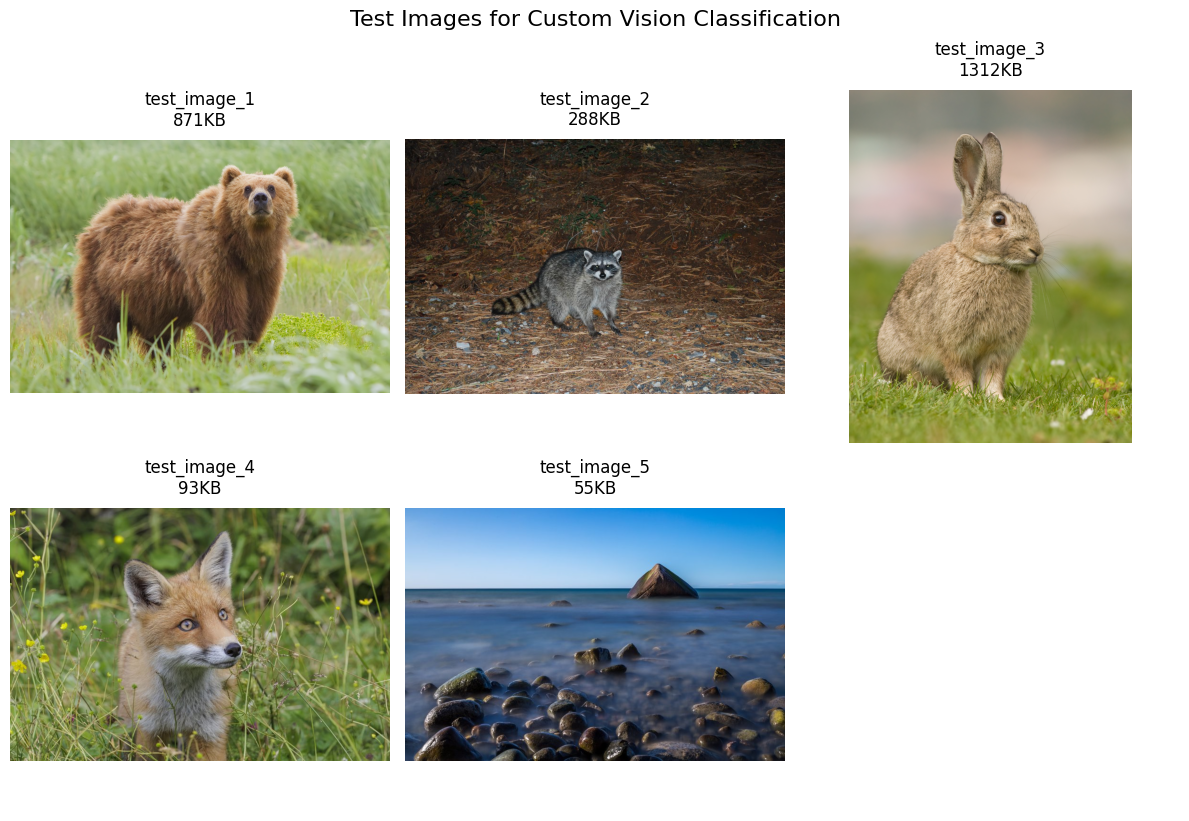


All images are optimized and ready for Custom Vision testing.
Images can be used directly for predictions via the Custom Vision API.

Successfully processed 5 test images.
These images are now ready for wildlife classification testing.


In [28]:
def download_and_preview_test_images(image_dict):
    """
    Download test images, resize for Custom Vision compatibility, and display in a grid.
    
    Features:
    - Downloads and optimizes images for Custom Vision testing
    - Creates a visual preview grid
    - Shows image names and optimized sizes
    """
    
    print("Downloading and preparing test images...")
    
    # Configuration matching our upload function
    headers = {'User-Agent': 'Mozilla/5.0 (compatible; Educational-Bot)'}
    max_file_size = 4 * 1024 * 1024  # 4MB target
    
    def optimize_image_for_preview(image_content, target_size=max_file_size):
        """Optimize image size while maintaining good preview quality."""
        try:
            img = PILImage.open(io.BytesIO(image_content))
            
            # Convert to RGB if necessary
            if img.mode in ('RGBA', 'P'):
                img = img.convert('RGB')
            
            # For preview, start with higher quality
            max_dimension = 800
            quality = 85  # Higher quality for preview
            
            # Only optimize if the image is too large
            if len(image_content) <= target_size:
                return img, len(image_content)
            
            while max_dimension >= 400:  # Don't go below 400px for preview
                img_resized = img.copy()
                img_resized.thumbnail((max_dimension, max_dimension), PILImage.Resampling.LANCZOS)
                
                # Try different quality levels
                for q in [quality, quality-15, quality-30]:
                    if q < 50:  # Don't go below 50% quality for preview
                        continue
                        
                    img_bytes = io.BytesIO()
                    img_resized.save(img_bytes, format='JPEG', quality=q, optimize=True)
                    
                    if len(img_bytes.getvalue()) <= target_size:
                        # Return the PIL image and final size
                        optimized_img = PILImage.open(io.BytesIO(img_bytes.getvalue()))
                        return optimized_img, len(img_bytes.getvalue())
                
                max_dimension -= 100
                
            # Final fallback
            img_small = img.copy()
            img_small.thumbnail((400, 400), PILImage.Resampling.LANCZOS)
            img_bytes = io.BytesIO()
            img_small.save(img_bytes, format='JPEG', quality=50, optimize=True)
            optimized_img = PILImage.open(io.BytesIO(img_bytes.getvalue()))
            return optimized_img, len(img_bytes.getvalue())
            
        except Exception as e:
            print(f"    Image optimization failed: {e}")
            return None, 0
    
    # Download and process images
    processed_images = {}
    image_sizes = {}
    
    for name, url in image_dict.items():
        try:
            print(f"Processing {name}...")
            
            # Download image
            response = requests.get(url, headers=headers, timeout=15)
            if response.status_code != 200:
                print(f"  Failed to download (HTTP {response.status_code})")
                continue
            
            original_size = len(response.content)
            print(f"  Original size: {original_size/1024/1024:.1f}MB")
            
            # Optimize for Custom Vision and preview
            optimized_img, final_size = optimize_image_for_preview(response.content)
            
            if optimized_img is not None:
                processed_images[name] = optimized_img
                image_sizes[name] = final_size
                print(f"  Optimized size: {final_size/1024:.0f}KB")
                print(f"  Dimensions: {optimized_img.size[0]}x{optimized_img.size[1]}px")
            else:
                print(f"  Failed to process image")
                
        except Exception as e:
            print(f"  Error processing {name}: {str(e)[:50]}...")
    
    # Create preview grid
    if processed_images:
        num_images = len(processed_images)
        cols = min(3, num_images)  # Max 3 columns
        rows = (num_images + cols - 1) // cols  # Calculate rows needed
        
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        
        # Handle single image case
        if num_images == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes if isinstance(axes, list) else [axes]
        else:
            axes = axes.flatten()
        
        print(f"\nDisplaying {num_images} test images:")
        
        for idx, (name, img) in enumerate(processed_images.items()):
            axes[idx].imshow(img)
            axes[idx].set_title(f"{name}\n{image_sizes[name]/1024:.0f}KB", fontsize=12, pad=10)
            axes[idx].axis('off')
        
        # Hide empty subplots
        for idx in range(num_images, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.suptitle('Test Images for Custom Vision Classification', fontsize=16, y=1.02)
        plt.show()
        
        print(f"\nAll images are optimized and ready for Custom Vision testing.")
        print(f"Images can be used directly for predictions via the Custom Vision API.")
        
        return processed_images
    else:
        print("No images were successfully processed.")
        return {}

# Execute the download and preview
test_images = download_and_preview_test_images(testing_images)

print(f"\nSuccessfully processed {len(test_images)} test images.")
print("These images are now ready for wildlife classification testing.")

## Publish the Trained Model

Before you can use your trained model for prediction, it must be published via Azure's API. This step assigns a name to the model and makes it accessible for inference requests.

**This function:**
- Publishes the most recent training iteration
- Enables subsequent prediction calls using the published endpoint

> You only need to publish once per training iteration. If you retrain the model, it must be re-published.

In [36]:
## Publish Model for Predictions

def publish_trained_model(project_id, prediction_resource_id):
    """
    Publish the trained model iteration to make it available for predictions.
    
    In Custom Vision, models must be published before they can be used 
    for predictions via the API.
    """
    
    print("📢 Publishing trained model for predictions...")
    
    try:
        # Get the latest trained iteration
        iterations = trainer.get_iterations(project_id)
        if not iterations:
            print("❌ No trained iterations found. Please train a model first.")
            return None
            
        latest_iteration = iterations[0]  # Most recent iteration
        
        print(f"🔍 Found iteration: {latest_iteration.name}")
        print(f"   Status: {latest_iteration.status}")
        
        if latest_iteration.status != "Completed":
            print(f"❌ Cannot publish - iteration status is '{latest_iteration.status}'")
            print("   Please ensure model training has completed successfully.")
            return None
        
        # Publish the iteration
        publish_name = f"WildlifeClassifier_v1"  # Simple, consistent name
        
        print(f"📤 Publishing as '{publish_name}'...")
        
        trainer.publish_iteration(
            project_id,
            latest_iteration.id,
            publish_name,
            prediction_resource_id
        )
        
        print("✅ Model published successfully!")
        print(f"🏷️  Published name: {publish_name}")
        print("🔗 Model is now available for predictions via API")
        print()
        print("✨ Your wildlife classifier is ready for testing!")
        
        return publish_name
        
    except Exception as e:
        print(f"❌ Error publishing model: {e}")
        print()
        print("💡 Common solutions:")
        print("   • Check that PREDICTION_RESOURCE_ID is correct in your setup")
        print("   • Ensure your Azure credentials have publish permissions")
        print("   • Verify the model training completed successfully")
        return None

# Execute model publishing
if project and PREDICTION_RESOURCE_ID:
    print("Preparing your wildlife classifier for predictions...")
    print()
    
    published_name = publish_trained_model(project.id, PREDICTION_RESOURCE_ID)
    
    if published_name:
        print(f"🎉 Success! Your model '{published_name}' is published and ready for testing.")
        print("🚀 Proceed to the next cell to test your wildlife classifier!")
    else:
        print("⚠️ Publishing failed. Please check the error messages above.")
        
else:
    if not project:
        print("❌ Project not found. Please run the project setup cell first.")
    if not PREDICTION_RESOURCE_ID:
        print("❌ PREDICTION_RESOURCE_ID not configured. Please check your Azure setup.")

Preparing your wildlife classifier for predictions...

📢 Publishing trained model for predictions...
🔍 Found iteration: Iteration 1
   Status: Completed
📤 Publishing as 'WildlifeClassifier_v1'...
✅ Model published successfully!
🏷️  Published name: WildlifeClassifier_v1
🔗 Model is now available for predictions via API

✨ Your wildlife classifier is ready for testing!
🎉 Success! Your model 'WildlifeClassifier_v1' is published and ready for testing.
🚀 Proceed to the next cell to test your wildlife classifier!


## Find Prediction Endpoint:

In order to use our model, we must find the prediction endpoint. This cell executes code that does this, in preparation for predicting.

In [42]:
## Find Correct Prediction Endpoint

print("🔍 FINDING YOUR CORRECT PREDICTION ENDPOINT")
print("=" * 50)
print()

print("📋 CURRENT SETUP:")
print(f"   Training endpoint: {ENDPOINT}")
print(f"   Using prediction key: {'✅ Yes' if PREDICTION_KEY else '❌ No'}")
print()

print("🎯 LIKELY PREDICTION ENDPOINTS TO TRY:")
print()

# Extract base name from training endpoint
import re
training_match = re.search(r'https://([^.]+)\.cognitiveservices\.azure\.com', ENDPOINT)

prediction_endpoints = []
if training_match:
    base_name = training_match.group(1)  # This should be 'wildlifcvtraining'
    
    # Common prediction endpoint patterns
    prediction_endpoints = [
        f"https://{base_name}-prediction.cognitiveservices.azure.com/",
        f"https://{base_name}.cognitiveservices.azure.com/",  # Single resource
        ENDPOINT  # Sometimes training endpoint works for predictions too
    ]
    
    print("Try these endpoints in order of likelihood:")
    for i, endpoint in enumerate(prediction_endpoints, 1):
        print(f"   {i}. {endpoint}")
else:
    print("❌ Could not parse training endpoint to suggest prediction endpoint")
    prediction_endpoints = [ENDPOINT]  # Fallback to current endpoint

print()
print("🔧 TESTING PREDICTION ENDPOINTS:")
print()

# Ensure we have endpoints to test
if not prediction_endpoints:
    prediction_endpoints = [ENDPOINT]

# Test each potential endpoint
for i, test_endpoint in enumerate(prediction_endpoints, 1):
    print(f"Testing option {i}: {test_endpoint}")
    
    try:
        # Create prediction client with this endpoint
        test_credentials = ApiKeyCredentials(in_headers={"Prediction-key": PREDICTION_KEY})
        test_predictor = CustomVisionPredictionClient(test_endpoint, test_credentials)
        
        # Test with a simple prediction
        if test_images and project:
            test_image_name = list(test_images.keys())[0]
            test_image = test_images[test_image_name]
            
            # Convert to bytes
            img_bytes = io.BytesIO()
            test_image.save(img_bytes, format='JPEG', quality=95)
            img_bytes.seek(0)
            
            # Try prediction
            result = test_predictor.classify_image(
                project.id,
                "WildlifeClassifier_v1",
                img_bytes.getvalue()
            )
            
            if result.predictions:
                top_pred = max(result.predictions, key=lambda x: x.probability)
                confidence = top_pred.probability * 100
                
                print(f"   ✅ SUCCESS! This endpoint works!")
                print(f"      Test prediction: {top_pred.tag_name} ({confidence:.1f}% confidence)")
                print()
                
                # Update the global predictor and endpoint
                globals()['predictor'] = test_predictor
                globals()['PREDICTION_ENDPOINT'] = test_endpoint
                
                print(f"🎉 Prediction client updated successfully!")
                print(f"📡 Using endpoint: {test_endpoint}")
                print(f"🔑 Using your prediction key")
                print()
                print("🚀 You can now run the prediction cell successfully!")
                
                break
            else:
                print(f"   ⚠️ Endpoint accessible but no predictions returned")
                
    except Exception as e:
        error_msg = str(e)[:60]
        print(f"   ❌ Failed: {error_msg}...")

print()
print("💡 MANUAL SETUP INSTRUCTIONS:")
print("If none of the automatic tests worked:")
print("1. Go to Azure Portal → Your Custom Vision resource")
print("2. Look for 'Prediction' endpoint (different from training)")  
print("3. Update ENDPOINT variable to use the prediction URL")
print("4. Ensure PREDICTION_KEY matches the prediction resource")
print("5. Or create a single 'All-in-one' Custom Vision resource")

🔍 FINDING YOUR CORRECT PREDICTION ENDPOINT

📋 CURRENT SETUP:
   Training endpoint: https://wildlifcvtraining.cognitiveservices.azure.com/
   Using prediction key: ✅ Yes

🎯 LIKELY PREDICTION ENDPOINTS TO TRY:

Try these endpoints in order of likelihood:
   1. https://wildlifcvtraining-prediction.cognitiveservices.azure.com/
   2. https://wildlifcvtraining.cognitiveservices.azure.com/
   3. https://wildlifcvtraining.cognitiveservices.azure.com/

🔧 TESTING PREDICTION ENDPOINTS:

Testing option 1: https://wildlifcvtraining-prediction.cognitiveservices.azure.com/
   ✅ SUCCESS! This endpoint works!
      Test prediction: bear (95.3% confidence)

🎉 Prediction client updated successfully!
📡 Using endpoint: https://wildlifcvtraining-prediction.cognitiveservices.azure.com/
🔑 Using your prediction key

🚀 You can now run the prediction cell successfully!

💡 MANUAL SETUP INSTRUCTIONS:
If none of the automatic tests worked:
1. Go to Azure Portal → Your Custom Vision resource
2. Look for 'Prediction'

## Make Predictions Using the Trained Model

This function sends your test images to the published Custom Vision model and retrieves the predicted tags along with confidence scores.

**The output includes:**
- A display of each image
- The predicted tags and their corresponding probability scores

> Use these results to evaluate how well the model generalises to new, unseen images.

Running wildlife classification predictions...
Testing with 5 images using your published model.

🔬 Testing Wildlife Classification Model
Testing 5 images...
Using published model: WildlifeClassifier_v1

🔍 Analyzing test_image_1...
  ✅ Predicted: bear (95.3% confidence)
🔍 Analyzing test_image_2...
  ✅ Predicted: raccoon (93.1% confidence)
🔍 Analyzing test_image_3...
  ✅ Predicted: rabbit (99.8% confidence)
🔍 Analyzing test_image_4...
  ✅ Predicted: coyote (72.8% confidence)
🔍 Analyzing test_image_5...
  ✅ Predicted: empty (70.6% confidence)

📊 CLASSIFICATION RESULTS


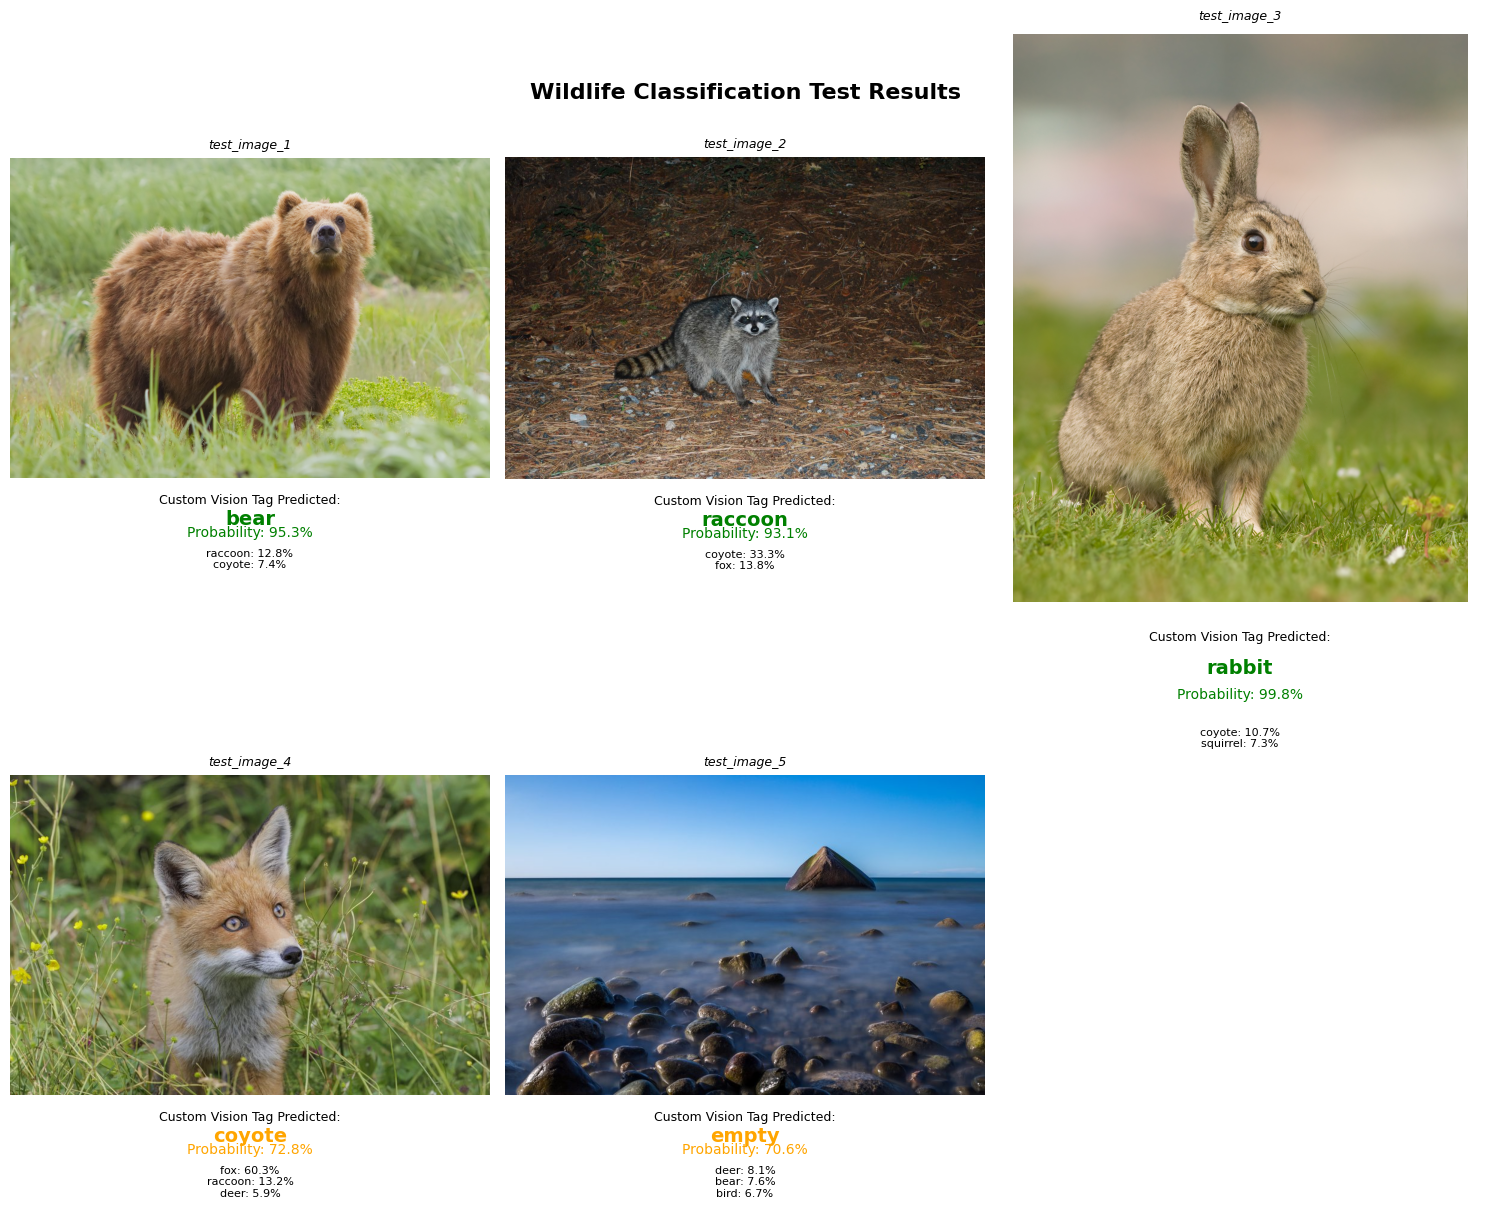


📋 DETAILED RESULTS:
Image               Predicted Tag    Confidence   Status
------------------------------------------------------------
test_image_1      bear           95.3%        🟢 High Confidence
test_image_2      raccoon        93.1%        🟢 High Confidence
test_image_3      rabbit         99.8%        🟢 High Confidence
test_image_4      coyote         72.8%        🟡 Medium Confidence
test_image_5      empty          70.6%        🟡 Medium Confidence

💡 RESULTS INTERPRETATION:
   🎯 High confidence predictions: 3/5
   ⚠️  Some predictions have lower confidence. Consider:
      • Adding more training images
      • Using higher quality test images
      • Ensuring test images clearly show the animals

🔬 RESEARCH APPLICATIONS:
   • Automated camera trap processing
   • Wildlife population monitoring
   • Biodiversity assessment
   • Conservation project automation

✅ Testing complete! Analyzed 5 images.
Your wildlife classification model is working successfully! 🎉


In [44]:
## Test Wildlife Classification Model

def test_wildlife_predictions(processed_images, project_id, published_name="WildlifeClassifier_v1"):
    """
    Test the trained wildlife classification model on test images using the published model.
    
    Features:
    - Runs predictions on your test images using the published model
    - Displays results in a visual grid
    - Shows predicted tags and confidence percentages
    - Provides interpretation of results
    """
    
    if not processed_images:
        print("❌ No test images available. Please run the image download cell first.")
        return
    
    print("🔬 Testing Wildlife Classification Model")
    print("=" * 45)
    print(f"Testing {len(processed_images)} images...")
    print(f"Using published model: {published_name}")
    print()
    
    predictions_results = {}
    
    # Run predictions on each test image
    for image_name, pil_image in processed_images.items():
        try:
            print(f"🔍 Analyzing {image_name}...")
            
            # Convert PIL image to bytes for prediction API
            img_bytes = io.BytesIO()
            pil_image.save(img_bytes, format='JPEG', quality=95)
            img_bytes.seek(0)
            
            # Make prediction using published model
            result = predictor.classify_image(
                project_id, 
                published_name,  # Use published name instead of iteration_id
                img_bytes.getvalue()
            )
            
            # Extract top prediction
            if result.predictions:
                top_prediction = max(result.predictions, key=lambda x: x.probability)
                predictions_results[image_name] = {
                    'image': pil_image,
                    'predicted_tag': top_prediction.tag_name,
                    'confidence': top_prediction.probability,
                    'all_predictions': result.predictions
                }
                
                confidence_pct = top_prediction.probability * 100
                print(f"  ✅ Predicted: {top_prediction.tag_name} ({confidence_pct:.1f}% confidence)")
            else:
                print(f"  ❌ No predictions returned")
                
        except Exception as e:
            print(f"  ❌ Error predicting {image_name}: {str(e)[:50]}...")
    
    # Display results in a grid
    if predictions_results:
        print(f"\n📊 CLASSIFICATION RESULTS")
        print("=" * 30)
        
        num_images = len(predictions_results)
        cols = min(3, num_images)  # Max 3 columns
        rows = (num_images + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 8*rows))
        
        # Handle single image case
        if num_images == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes if isinstance(axes, list) else [axes]
        else:
            axes = axes.flatten()
        
        for idx, (image_name, result) in enumerate(predictions_results.items()):
            img = result['image']
            predicted_tag = result['predicted_tag']
            confidence = result['confidence']
            all_predictions = result['all_predictions']
            
            # Display image
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            # Color code confidence levels for main prediction
            confidence_pct = confidence * 100
            if confidence >= 0.8:
                color = 'green'
            elif confidence >= 0.6:
                color = 'orange'
            else:
                color = 'red'
            
            # Prepare other predictions (smaller, black)
            other_predictions = [p for p in all_predictions if p.tag_name != predicted_tag]
            other_predictions = sorted(other_predictions, key=lambda x: x.probability, reverse=True)
            
            other_text_lines = []
            for pred in other_predictions[:3]:  # Show top 3 other predictions
                other_pct = pred.probability * 100
                if other_pct > 5:  # Only show if >5% confidence
                    other_text_lines.append(f"{pred.tag_name}: {other_pct:.1f}%")
            
            # Position main prediction text below image with label
            label_text = "Custom Vision Tag Predicted:"
            main_text = f"{predicted_tag}"
            prob_text = f"Probability: {confidence_pct:.1f}%"
            
            # Small label
            axes[idx].text(0.5, -0.05, label_text, 
                          transform=axes[idx].transAxes, 
                          ha='center', va='top',
                          fontsize=9, color='black')
            
            # Main prediction (larger, colored)
            axes[idx].text(0.5, -0.10, main_text, 
                          transform=axes[idx].transAxes, 
                          ha='center', va='top',
                          fontsize=14, color=color, weight='bold')
            
            # Probability
            axes[idx].text(0.5, -0.15, prob_text, 
                          transform=axes[idx].transAxes, 
                          ha='center', va='top',
                          fontsize=10, color=color)
            
            # Add other predictions below main prediction
            if other_text_lines:
                other_text = '\n'.join(other_text_lines)
                axes[idx].text(0.5, -0.22, other_text, 
                              transform=axes[idx].transAxes, 
                              ha='center', va='top',
                              fontsize=8, color='black')
            
            # Add image name at the top in small text
            axes[idx].text(0.5, 1.02, image_name, 
                          transform=axes[idx].transAxes, 
                          ha='center', va='bottom',
                          fontsize=9, color='black', style='italic')
        
        # Hide empty subplots
        for idx in range(num_images, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.25)  # Add more space at bottom for multi-line text
        plt.suptitle('Wildlife Classification Test Results', fontsize=16, y=0.96, weight='bold')
        plt.show()
        
        # Display detailed results table
        print("\n📋 DETAILED RESULTS:")
        print("Image               Predicted Tag    Confidence   Status")
        print("-" * 60)
        
        for image_name, result in predictions_results.items():
            tag = result['predicted_tag'].ljust(12)
            conf_pct = f"{result['confidence']*100:.1f}%".ljust(10)
            
            if result['confidence'] >= 0.8:
                status = "🟢 High Confidence"
            elif result['confidence'] >= 0.6:
                status = "🟡 Medium Confidence"
            else:
                status = "🔴 Low Confidence"
            
            name_short = image_name[:15].ljust(15)
            print(f"{name_short}   {tag}   {conf_pct}   {status}")
        
        # Performance interpretation
        print(f"\n💡 RESULTS INTERPRETATION:")
        high_conf_count = sum(1 for r in predictions_results.values() if r['confidence'] >= 0.8)
        total_count = len(predictions_results)
        
        print(f"   🎯 High confidence predictions: {high_conf_count}/{total_count}")
        
        if high_conf_count == total_count:
            print("   🌟 Excellent! All predictions have high confidence.")
        elif high_conf_count >= total_count * 0.8:
            print("   ✅ Good performance! Most predictions are confident.")
        else:
            print("   ⚠️  Some predictions have lower confidence. Consider:")
            print("      • Adding more training images")
            print("      • Using higher quality test images")
            print("      • Ensuring test images clearly show the animals")
        
        print(f"\n🔬 RESEARCH APPLICATIONS:")
        print("   • Automated camera trap processing")
        print("   • Wildlife population monitoring")
        print("   • Biodiversity assessment")
        print("   • Conservation project automation")
        
        return predictions_results
    else:
        print("❌ No successful predictions to display.")
        return {}

# Execute wildlife classification testing
if project and test_images:
    print("Running wildlife classification predictions...")
    print(f"Testing with {len(test_images)} images using your published model.")
    print()
    
    # Check if we have a published model name from previous cell
    if 'published_name' in globals() and published_name:
        prediction_results = test_wildlife_predictions(test_images, project.id, published_name)
    else:
        # Fallback to default published name
        print("Using default published model name: WildlifeClassifier_v1")
        prediction_results = test_wildlife_predictions(test_images, project.id, "WildlifeClassifier_v1")
    
    if prediction_results:
        print(f"\n✅ Testing complete! Analyzed {len(prediction_results)} images.")
        print("Your wildlife classification model is working successfully! 🎉")
    else:
        print("\n⚠️ Testing was not successful. Please check the error messages above.")
        
else:
    if not project:
        print("❌ Project not found. Please run the project setup cell first.")
    if not test_images:
        print("❌ No test images found. Please run the test image download cell first.")

## Further work:

If you are literate in Python, you can use the code cells above to test any images you want. Simply replace the URLs given in each of the training and testing dictionaries, and replace the tags in the categories dictionary, within the `setup_wildlife_project` function to correspond with the labels in your images. Feel free to play and experiment with this code as much as you like.

## Summary and Learning Outcomes

Congratulations! You have successfully completed this section of the Azure Custom Vision training course.

By following the steps and running the cells in this notebook, you have:

- Installed and configured the required packages and services
- Connected securely to Azure Custom Vision using your credentials
- Created a new image classification project with multiple categories
- Uploaded and labelled training data from online image sources
- Trained a multi-label classification model using Azure AI
- Evaluated model performance through precision and recall metrics
- Published the trained model for use in real-world predictions
- Tested the model by sending unseen images and analysing the predictions

### ✅ Learning Outcomes Achieved:
- Understand how to use Azure Custom Vision via Python
- Automate dataset preparation and model training workflows
- Interpret classification results and model confidence scores
- Gain experience integrating AI services into practical applications

> You are now ready to build and test your own custom image classifiers using Azure’s powerful AI platform.